# "Autoregressive Generative Models"
> "An overview on Autoregressive Generative Models (MADE, PixelCNN, Conditional PixelCNN, PixelCNN++) with implementation code"

- toc: true
- branch: master
- badges: true
- comments: true
- author: Thanh Tu NGUYEN
- categories: [generative, autoregressive, deeplearning]

# Introduction

**Generative model** is a subset of unsupervised learning which has been recieving a lot of attention for last few years. The idea is that given a training dataset, we will use models or algorithms to generate new samples with the same distribution. 

    “What I cannot create, I do not understand.”
    —Richard Feynman

Suppose we have a dataset containing images of dogs. We may wish to build a model that can generate a new image of a dog that has never existed but still looks real because the model has learned the general rules that govern the appearance of a dog. This is the kind of problem that can be solved using **generative modeling**.

In mathematical terms, **generative modeling** estimates $p(x)$ —the probability of observing observation $x$. In fact, our model tries to learn to construct an estimate $p_{model}(x)$ as similar as possible to the probability density function $p_{data}(x)$. 

In this blog, we will take a deep look at one of popular approaches to tackle this problem which is **Autoregressive Generative Models**

# Autoregressive Generative Model

The idea behind this type of model is that if we consider all obversations as a sequence, the probability of observing one data point depends only on the previous ones but not the ones after it, we can compute $p(x)$ as a product of conditional distributions by applying [product rule](https://en.wikipedia.org/wiki/Chain_rule_(probability)). In a nutshel, autoregressive models define the **joint distribution** using conditionals over each feature, given the values of the previous features. 

$$\mathbf{p}(\mathbf{x}) = \prod_{i=1}^{N} \mathbf{x}_i = \prod_{i=1}^{N} \mathbf{p}\big(\mathbf{x}_i | \mathbf{x}_1, \mathbf{x}_2, ..., \mathbf{x}_{i-1}\big) \tag{1}$$

For example, we can use autoregressive generative models to predict the output at timestep t given its previous timesteps in text-to-speech problem. Or the probability of a pixel from an image to have a specific intensity value is conditioned by the values of all previous pixels; and the probability of an image (the joint distribution of all pixels) is the combination of the probability of all its pixels.

## Masked Autoencoder for Distribution Estimation (MADE)

The idea of MADE is built on top of autoencoder architecture. So, we'll have a quick look on vanila autoencoder.

### Autoencoder

Our primary goal is take an input sample $\mathbf{x}$ and transform it to some latent dimension $\mathbf{z}$ (**encoder**), which hopefully is a good representation of the original data. 

    what is a good representation?  
    "A good representation is one where you can reconstruct the original input!". 

The process of transforming the latent dimension $\mathbf{z}$ back to a reconstructed version of the input $\mathbf{\hat{x}}$ is called the **decoder**. It's an **autoencoder** because it's using the same value $\mathbf{x}$ value on the input and output.

Mathematically, an **encoder** is mapping an input $\mathbf{x}$ to a feature vector $\mathbf{h} = \mathbf{f}_{\theta}(\mathbf{x})$ while a **decoder** tries to map from feature space back into input space producing a **reconstruction** $\mathbf{\hat{x}}= \mathbf{g}_{\theta}(\mathbf{h}) = \mathbf{g}_{\theta}\big(\mathbf{f}_{\theta}(\mathbf{x})\big)$. The  set  of  parameters $\theta$ of  the encoder  and  decoder  are  learned  simultaneously  on  the  task of  reconstructing  as  well  as  possible  the  original  input,  i.e.attempting to incur the lowest possible **reconstruction  error** $\mathcal{L}(\mathbf{x},\mathbf{\hat{x}})$ -  a  measure  of  the  discrepancy  between $\mathbf{x}$ and  its reconstruction $\mathbf{\hat{x}}$ - over training examples


![](https://upload.wikimedia.org/wikipedia/commons/2/28/Autoencoder_structure.png "Figure 1: Vanilla autoencoder")

To train autoencoder, we use cross-entropy loss:
\begin{align*}
\mathcal{L_{\text{binary}}}({\bf \mathbf{x}}) &= \sum_{i=1}^N -\mathbf{x}_i\log \hat{\mathbf{x}}_i - (1-\mathbf{x}_i)\log(1-\hat{\mathbf{x}_i}) \tag{2} \\
\end{align*}

To capture  the  structure  of  the  data-generating  distribution,  it is  therefore  important  that  something  in  the  training  criterion  or  the  parametrization  prevents  the  auto-encoder  from learning  the  identity  function,  which  has  zero  reconstruction error  everywhere.  This  is  achieved  through  various  means **regularized autoencoders** (refer to [3] to see more about it)

###  Masked Autoencoders

Since autoencoder is to reconstruct the input from learning a latent representation of data in an unsupervised manner, it can't provide a proper probability distribution. Therefore, it can usually be used in applications such as denoising images but can't generate a total new sample. 

The reason is that in autoencoder, each output $\mathbf{\hat{x}}_i$ could depend on any of the components input $\mathbf{x}_1,…,\mathbf{x}_n$. So in order to convert to our autoregressive models as defined above, we can modify the structure so that $\mathbf{\hat{x}}_i$ only depend on previous components $\mathbf{x}_1,…,\mathbf{x}_{i-1}$ but not the future ones $\mathbf{x}_{i+1},…,\mathbf{x}_n$. 

The principle becomes as following:
- Each output of the network $\mathbf{\hat{x}}_i$ represents the probability distribution $\mathbf{p}\big(\mathbf{x}_i | \mathbf{x}_{<i}\big)$

- Each output $\mathbf{\hat{x}}_i$ can only have connections (recursively) to smaller indexed inputs $\mathbf{x}_{<i}$ and not any of the other ones.

To persuit this principle, the MADE authors came up with the idea of **masked autoencoders**. Since output $\mathbf{\hat{x}}_i$ must depend only on the preceding inputs $\mathbf{x}_{<i}$,  it means that there must be no computational path between output unit $\mathbf{\hat{x}}_i$ and any of the input units $\mathbf{x}_i, ... \mathbf{x}_N$. To do so, we will **zero-out the weights** we don't want by creating a binary mask matrix, whose entries that are set to 0 correspond to the connections we wish to remove.

Take a simple case when encoder and decoder are only one layer of feed-forward.

\begin{align*}
{\bf h}({\bf x}) &= {\bf g}({\bf b} + {\bf Wx}) \\
{\hat{\bf x}} &= \text{sigm}({\bf c} + {\bf V h(x)})  
\end{align*}

where 
- $\odot$ is an element wise product

- ${\bf x}, \hat{\bf x}$ is our vectors of input/output respectively

- $\bf h(x)$ is the hidden layer

- $\bf g(⋅)$ is the activation function of the hidden layer

- $\text{sigm}$ is the sigmoid activation function of the output layer

- $\bf b$, $\bf c$ are the constant biases for the hidden/output layer respectively

- $\bf W$, $\bf V$  are the weight matrices for the hidden/output layer respectively


Denote $\bf M^W$, $\bf M^V$ the masks for $\bf W$ and $\bf V$ respectively. The equations with masked autoencoders become:

$$\begin{align*}
{\bf h}({\bf x}) &= {\bf g}({\bf b} + {\bf (W \odot M^W)x}) \\
{\hat{\bf x}} &= \text{sigm}({\bf c} + {\bf (V \odot M^V)h(x)})  
\end{align*}
$$

The last problem is only find a way to construct masks $\bf M^W$, $\bf M^V$ which sastify autoregressive property.       
Let $m^{l}(k)$ be the index assigned to hidden node $k$ in layer $l$. The condition would be as follows:

- First, for each hidden layer $l$, we sample $m^{l}(k)$ from a uniform distribution with range $[1,D−1]$. The index $D$ should be never used because nothing should depend on $D^{th}$ input
- For a given node, it only connects to nodes in the previous layer that have an index less than or equal to its index.

$$\ M^{W^l}_{k', k} =  \begin{cases}
                      1 \text{ if } m^l(k') \geq m^{l-1}(k)  \\
                      0 \text{ otherwise}
                    \end{cases}
\
$$
- The output mask is slightly different:

$$\ M^{V}_{d, k} = \begin{cases}
                    1 \text{ if } d > m^{L}(k)  \\
                    0 \text{ otherwise}
                   \end{cases}
\
$$

![](my_icons/MADE_archi.png "Figure 2: MADE")

In figure 2:
- output 1 is not connected to anything. It will just be estimated with a single constant parameter derived from the bias node. Otherwise, output 2 is only connected to hiddens which are only connected to input 1. Finally, output 3 is connected to hiddens which come from input 1 and input 2 

- On the other hand, input 3 is connected to nothing because no node should depend on it (autoregressive property).

### Discussion

1. Does ordering of input matters?  

Actually, there is no natural ordering input. We can shuffle the input dimensions, so that MADE is able to model any arbitrary ordering.

2. How can we generate new samples?

Sampling steps:
- Randomly generate vector x, set $i=1$
- Feed $\bf x$ into autoencoder and generate outputs $\hat{\bf x}$ for the network, set $p =\bf \hat{x}_i$
- Sample from a Bernoulli distribution with parameter p, set input ${\bf x}_i=Bernoulli(p)$
- Increment $i$ and repeat steps 2-4 until $i > D$.

### Implementation
   >The Pytorch code implementation of MADE is borrowed from this [repo](https://github.com/rll/deepul).   
   > In this example, We will build a network training on binarized MNIST dataset 

In [2]:
#collapse-hide

from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
import torch
import torch.utils.data as data
from torch import optim
from torch import nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def load_data():
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        lambda x: (x > 0.5).float() #binarize image
    ])
    train_dset = MNIST('data', transform=transform, train=True, download=True)
    test_dset = MNIST('data', transform=transform, train=False, download=True)

    train_loader = data.DataLoader(train_dset, batch_size=128, shuffle=True,
                                   pin_memory=True, num_workers=2)
    test_loader = data.DataLoader(test_dset, batch_size=128, shuffle=True,
                                  pin_memory=True, num_workers=2)

    return train_loader, test_loader

def plot_train_curves(epochs, train_losses, test_losses, title=''):
    x = np.linspace(0, epochs, len(train_losses))
    plt.figure()
    plt.plot(x, train_losses, label='train_loss')
    if test_losses:
        plt.plot(x, test_losses, label='test_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.show()

def visualize_batch(batch_tensor, nrow=8, title='', figsize=None):
    grid_img = make_grid(batch_tensor, nrow=nrow)
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')
    plt.show()
    
train_loader, test_loader = load_data()

In [3]:
#collapse-hide

def train(model, train_loader, optimizer):
    model.train()
    for x, _ in train_loader:
        loss = model.nll(x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return model


def eval_loss(model, data_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x, _ in data_loader:
            loss = model.nll(x)
            total_loss += loss * x.shape[0]
        avg_loss = total_loss / len(data_loader.dataset)
    return avg_loss.item()


def train_epochs(model, train_loader, test_loader, train_args):
    epochs, lr = train_args['epochs'], train_args['lr']
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, test_losses = [], []
    
    samples = model.sample(64)
    visualize_batch(samples, title=f'Intialization')
    for epoch in range(epochs):
        model.train()

        model = train(model, train_loader, optimizer)
        train_loss = eval_loss(model, train_loader)
        train_losses.append(train_loss)

        if test_loader is not None:
            test_loss = eval_loss(model, test_loader)
            test_losses.append(test_loss)
            
        samples = model.sample(64)
        if epoch % 10 == 0:    
            print(f'Epoch {epoch} Test Loss: {test_losses[epoch] / np.log(2):.4f} bits/dim')
            visualize_batch(samples, title=f'Epoch {epoch}')
        
    if test_loader is not None:
        print('Test Loss', test_loss)

    plot_train_curves(epochs, train_losses, test_losses, title='Training Curve')

In [4]:
class MaskedLinear(nn.Linear):
    """ same as Linear except has a configurable mask on the weights """

    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias)
        self.register_buffer('mask', torch.ones(out_features, in_features))

    def set_mask(self, mask):
        self.mask.data.copy_(torch.from_numpy(mask.astype(np.uint8).T))

    def forward(self, input):
        return F.linear(input, self.mask * self.weight, self.bias)


class MADE(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.nin = 784 #28 * 28
        self.nout = 784
        self.hidden_sizes = [512, 512, 512]
        self.device = device

        # define a simple MLP neural net
        self.net = []
        hs = [self.nin] + self.hidden_sizes + [self.nout]
        for h0, h1 in zip(hs, hs[1:]):
            self.net.extend([
                MaskedLinear(h0, h1),
                nn.ReLU(),
            ])
        self.net.pop()  # pop the last ReLU for the output layer
        self.net = nn.Sequential(*self.net).to(device)

        self.m = {}
        self.create_mask()  # builds the initial self.m connectivity

    def create_mask(self):
        L = len(self.hidden_sizes)

        # sample uniform distribution the order of the inputs and the connectivity of all neurons
        self.m[-1] = np.arange(self.nin)
        for l in range(L):
            self.m[l] = np.random.randint(self.m[l - 1].min(), self.nin - 1, size=self.hidden_sizes[l])

        # construct the mask matrices
        masks = [self.m[l - 1][:, None] <= self.m[l][None, :] for l in range(L)]
        masks.append(self.m[L - 1][:, None] < self.m[-1][None, :])

        # set the masks in all MaskedLinear layers
        layers = [l for l in self.net.modules() if isinstance(l, MaskedLinear)]
        for l, m in zip(layers, masks):
            l.set_mask(m)

    def nll(self, x):
        x = x.view(-1, 784).to(self.device) # Flatten image
        logits = self.net(x)
        return F.binary_cross_entropy_with_logits(logits, x)

    def sample(self, n):
        samples = torch.zeros(n, 784).to(self.device)
        with torch.no_grad():
            for i in range(784):
                logits = self.net(samples)[:, i]
                probs = torch.sigmoid(logits)
                samples[:, i] = torch.bernoulli(probs)
            samples = samples.view(n, 1, 28, 28)
        return samples.cpu()

In [6]:
train_args = {'epochs': 20, 'lr': 0.01}
device = 'cuda'
model = MADE(device)

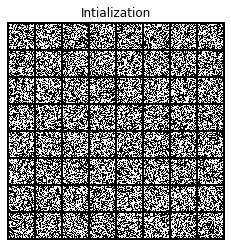

Epoch 0 Test Loss: 0.2613 bits/dim


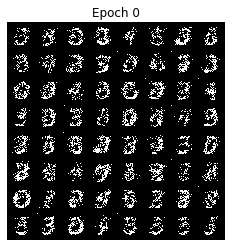

Epoch 5 Test Loss: 0.2191 bits/dim


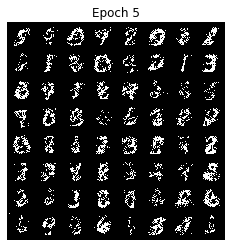

Epoch 10 Test Loss: 0.2124 bits/dim


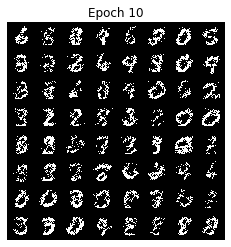

Epoch 15 Test Loss: 0.2096 bits/dim


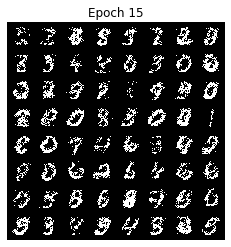

Test Loss 0.14515839517116547


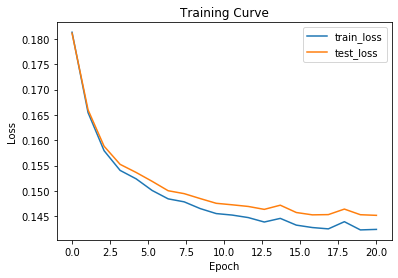

In [66]:
train_epochs(model, train_loader, test_loader, train_args)

## PixelCNN 

PixelCNN is a deep autoregressive generative model for images. Let's consider an image of size $n×n$, each pixel in image is a data point $\bf x=\big\{{\bf x_1,…,x_{n^2}}\big\}$. The model starts generating pixels from the top left corner, from left to right and top to bottom ([raster scanning](https://en.wikipedia.org/wiki/Raster_scan)).

![](my_icons/pixel_cnn.png "Figure 3: PixelCNN. Source[3]")

Each pixel $\bf{x}_i$ is in turn jointly determined by three values,one for each of the color channels Red, Green  and Blue (RGB). Each of the colors is thus conditioned on the other channels as well as on all the previously generated pixels.
$$\mathbf p( \mathbf x_i| \mathbf x_{<i}) = \mathbf p(\mathbf x_{i,R}|\mathbf x_{<i}). \mathbf p(x_{i,G}|\mathbf x_{<i},\mathbf x_{i,R}). \mathbf p(x_{i,B}|\mathbf x_{<i},\mathbf x_{i,R},\mathbf x_{i,G})$$

> Note: Along with PixelCNN, the paper authors also proposed PixelRNN with the same analogy as PixelCNN. However, PixelRNN with sequential dependency between LSTM states is very expensive for the computation. So this method will not be detailed in this blog. Check the [paper](https://arxiv.org/pdf/1601.06759.pdf) if you are interested in it.



### Masked spatial convolution

The masked use the convolution filter to slide over image which multiplies each element and sums them together to produce a single response. However, we cannot use this filter because a generated pixel should not know the intensities of future pixel values. To counter this issue, we use a mask on top of the filter to only choose prior pixels and zeroing the future pixels to negate them from calculation. 

![](https://wiki.math.uwaterloo.ca/statwiki/images/thumb/f/f0/masking1.png/320px-masking1.png "Figure 3 : Masked spatial convolution. [Source](https://wiki.math.uwaterloo.ca/statwiki/index.php?title=STAT946F17/Conditional_Image_Generation_with_PixelCNN_Decoders)")

### Blind spot

PixelCNN masking has one problem: **blind spot** in receptive field because the capturing of receptive field by a CNN proceed in a triangular fashion. 

![](my_icons/blind_spot_pixelCNN.png "Figure 4: Blind spot in PixelCNN")

 In order to address the blind spot, the authors use two filters (horizontal and vertical stacks) in conjunction to allow for capturing the whole receptive ﬁeld. 
- **Vertical stack**: conditions on all the pixels in the rows above the current pixel. It doesn't have any masking, allow the receptive field to grow in a rectangular fashion without any blind spot 
- **Horizontal stack**: conditions on the current row and takes as input the output of previous layer as well as of the vertical stack. 

![](https://wiki.math.uwaterloo.ca/statwiki/images/thumb/4/48/vh_stack.png/799px-vh_stack.png 'Figure 5: Vertical stack and horizontal stack to tackle blind spot problem')

### Gated PixelCNN

The PixelCNN only takes into consideration the neighborhood region and the depth of the convolution layers to make its predictions. To improve the performance of PixelCNN, the authors replaced the rectified linear units between the masked convolutions with the following gated activation function in order to model more complex interactions:
$$\mathbf{y} = \tanh (\mathbf W_{k,f} \ast \mathbf{x}) \odot \sigma (\mathbf W_{k,g} \ast \mathbf{x})$$

where:   
$*$ is the convolutional operator.   
$\odot$ is the element-wise product.   
$\sigma$ is the sigmoid non-linearity    
$k$ is the number of the layer   
$tanh(W_{k,f} \ast \mathbf x)$ is a classical convolution with tanh activation function.   
$\sigma(W_{k,g} \ast \mathbf x)$ are the gate values (0 = gate closed, 1 = gate open).   
$W_{k,f}$ and $W_{k,g}$ are learned weights.   
$f, g$ are the different feature maps   


A gated block is represented in Figure 6. There are 2 things to notice here:
1.  the vertical stack contributes to the horizontal stack with the $1\times1$ convolution while vertical stack should not access any information horizontal stack has - otherwise it will have access to pixels it shouldn’t see. However, the vertical stack can be vertically connected as it predicts pixel following those in the vertical stack.
2. The convolutions with $W_f$ and $W_g$ are not combined into a single operation (which is essentially the masked convolution) to increase parallelization. The parallelization splits the $2p$ features maps into two groups of $p$

![[Source](https://wiki.math.uwaterloo.ca/statwiki/index.php?title=STAT946F17/Conditional_Image_Generation_with_PixelCNN_Decoders#Conditional_PixelCNN)](https://wiki.math.uwaterloo.ca/statwiki/images/thumb/6/61/gated_block.png/800px-gated_block.png 'Figure 6: A gated PixelCNN block').

### Conditional PixelCNN

Sometimes we want to integrate some high-level information before feed the network, for example provising an image to the network with the associated classes in CIFAR datasets. During training we feed image as well as class to our network to make sure network would learn to incorporate that information as well. During inference we can specify what class our output image should belong to. 

For a conditional PixelCNN, we represent a provided high-level image description as a latent vector $\mathbf h$, wherein the purpose of the latent vector is to model the conditional distribution $p(\mathbf{x} \vert \mathbf{h})$ such that we get a probability as to if the images suites this description. The conditional PixelCNN models based on the following distribution: 
$$p(\mathbf{x} \vert \mathbf{h}) = \prod_{i=1}^{n^2} p(x_i \vert x_1, \cdots, x_{i-1}, \mathbf{h})$$

Add terms $\mathbf h$ before the non-linearities: 

$$ \mathbf{y} = \tanh (W_{k,f} \ast \mathbf{x}  {+ V_{k,f}^\top \mathbf{h}} ) \odot \sigma (W_{k,g} \ast \mathbf{x} {+ V_{k,g}^\top \mathbf{h} })$$

- If the latent vector $\mathbf h$ is a one-hot encoding vector that provides the class labels, which is equivalent to the adding a class dependent bias at every layer. So, the conditioning is dependent on “what should the image contain” rather than the location of contents in the image.
- To add the location dependency to the model, we use a transposed convolution to map $\mathbf h$ to a spatial representation $s=deconv(\mathbf h)$ to produce the output $\mathbf s$ of the same shape as the image:

$$\mathbf{y} = \tanh (W_{k,f} \ast \mathbf{x}  {+ V_{k,f} \ast \mathbf{s}} ) \odot \sigma (W_{k,g} \ast \mathbf{x} {+ V_{k,g} \ast \mathbf{s} })$$

### Implementation

>The Pytorch code implementation of Gated PixelCNN is borrowed from this [repo](https://github.com/rll/deepul).   

#### PixelCNN with blind spot

In [7]:
class MaskConv2d(nn.Conv2d):
    def __init__(self, mask_type, *args, **kwargs):
        assert mask_type == 'A' or mask_type == 'B'
        super().__init__(*args, **kwargs)
        self.register_buffer('mask', torch.zeros_like(self.weight))
        self.create_mask(mask_type)

    def forward(self, input):
        return F.conv2d(input, self.weight * self.mask, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)

    def create_mask(self, mask_type):
        k = self.kernel_size[0]
        self.mask[:, :, :k // 2] = 1
        self.mask[:, :, k // 2, :k // 2] = 1
        if mask_type == 'B':
            self.mask[:, :, k // 2, k // 2] = 1


class PixelCNN(nn.Module):
    def __init__(self, device):
        super().__init__()
        model = [MaskConv2d('A', 1, 64, 7, padding=3), nn.ReLU()]
        for _ in range(3):
            model.extend([MaskConv2d('B', 64, 64, 7, padding=3), nn.ReLU()])
        model.append(MaskConv2d('B', 64, 1, 7,padding=3))
        self.net = nn.Sequential(*model).to(device)
        self.device = device

    def nll(self, x):
        x = x.to(self.device)
        logits = self.net(x)
        return F.binary_cross_entropy_with_logits(logits, x)

    def sample(self, n):
        samples = torch.zeros(n, 1, 28, 28).to(self.device)
        with torch.no_grad():
            for r in range(28):
                for c in range(28):
                    logits = self.net(samples)[:, :, r, c]
                    probs = torch.sigmoid(logits)
                    samples[:, :, r, c] = torch.bernoulli(probs)
        return samples.cpu()

In [8]:
train_args = {'epochs': 21, 'lr': 0.0002}
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = PixelCNN(device)

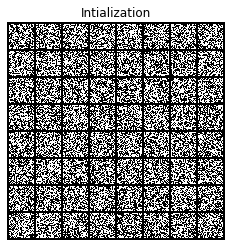

Epoch 0 Test Loss: 0.1629 bits/dim


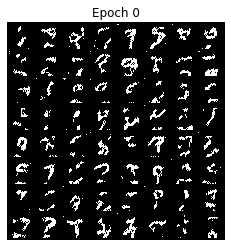

Epoch 10 Test Loss: 0.1217 bits/dim


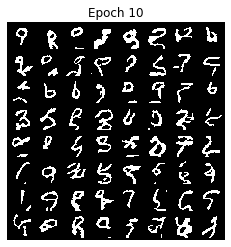

Epoch 20 Test Loss: 0.1177 bits/dim


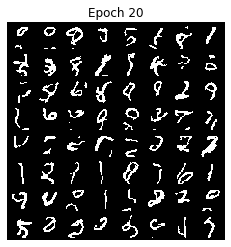

Test Loss 0.08157001435756683


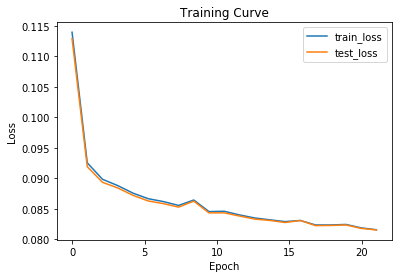

In [9]:
train_epochs(model, train_loader, test_loader, train_args)

#### PixelCNN without blind spot

In [80]:
class HoriVertStackConv2d(nn.Module):
    def __init__(self, mask_type, in_channels, out_channels, k=3, padding=1, 
                 gated=False, residual_horizontal=False):
        super().__init__()
        gm = 2 if gated else 1
        self.gated = gated
        self.out_channels = out_channels
        
        self.vertical = nn.Conv2d(in_channels, gm * out_channels, kernel_size=k,
                                  padding=padding, bias=False)
        self.horizontal = nn.Conv2d(in_channels, gm * out_channels, kernel_size=(1, k),
                                    padding=(0, padding), bias=False)
        self.vtohori = nn.Conv2d(gm * out_channels, gm * out_channels, kernel_size=1, bias=False)
        
        self.horizontal_output = nn.Conv2d(in_channels , out_channels, 1)
        self.residual_horizontal = residual_horizontal
            
        
        self.register_buffer('vmask', self.vertical.weight.data.clone())
        self.register_buffer('hmask', self.horizontal.weight.data.clone())

        self.vmask.fill_(1)
        self.hmask.fill_(1)

        # zero the bottom half rows of the vmask
        self.vmask[:, :, k // 2 + 1:, :] = 0

        # zero the right half of the hmask
        self.hmask[:, :, :, k // 2 + 1:] = 0
        if mask_type == 'A':
            self.hmask[:, :, :, k // 2] = 0
    
    def _gated(self, x):
        return torch.tanh(x[:, :self.out_channels]) * torch.sigmoid(x[:, self.out_channels:])
    
    def down_shift(self, x):
        x = x[:, :, :-1, :]
        pad = nn.ZeroPad2d((0, 0, 1, 0))
        return pad(x)

    def forward(self, x):
        vx, h = x.chunk(2, dim=1)

        self.vertical.weight.data *= self.vmask
        self.horizontal.weight.data *= self.hmask
            
        vx = self.vertical(vx)
        hx = self.horizontal(h)
        # Allow horizontal stack to see information from vertical stack
        hx = hx + self.vtohori(self.down_shift(vx))
        
        if self.gated:
            vx = self._gated(vx)
            hx = self._gated(hx)
        
        if self.residual_horizontal:
            h = self.horizontal_output(h)
            hx = h + hx
        
        return torch.cat((vx, hx), dim=1)

# PixelCNN using horizontal and vertical stacks to fix blind-spot
class GatedHoriVertStackPixelCNN(nn.Module):
    name = 'HoriVertStackPixelCNN'
    def __init__(self, n_layers, device):
        super().__init__()
        model = [HoriVertStackConv2d('A', 1, 64, 7, padding=3), nn.ReLU()]
        for _ in range(n_layers - 1):
            model.extend([HoriVertStackConv2d('B', 64, 64, 7, padding=3), 
                          nn.ReLU()])
        model.append(HoriVertStackConv2d('B', 64, 1, 7,padding=3))
        self.net = nn.Sequential(*model).to(device)
        self.device = device
        
    def forward(self, x):
        x = x.to(self.device)
        return self.net(torch.cat((x, x), dim=1)).chunk(2, dim=1)[1]
    
    def nll(self, x):
        x = x.to(self.device)
        logits = self(x)
        return F.binary_cross_entropy_with_logits(logits, x)

    def sample(self, n):
        samples = torch.zeros(n, 1, 28, 28) #here we sample only one channel instead of three for simplicity
        with torch.no_grad():
            for r in range(28):
                for c in range(28):
                    logits = self(samples)[:, :, r, c]
                    probs = torch.sigmoid(logits)
                    samples[:, :, r, c] = torch.bernoulli(probs)
        return samples.cpu()

In [81]:
train_args = {'epochs': 21, 'lr': 0.0002}
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = GatedHoriVertStackPixelCNN(4, device)

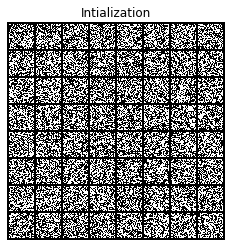

Epoch 0 Test Loss: 0.3259 bits/dim


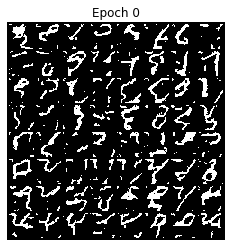

Epoch 10 Test Loss: 0.3033 bits/dim


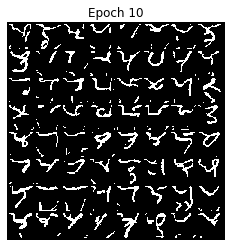

Epoch 20 Test Loss: 0.3007 bits/dim


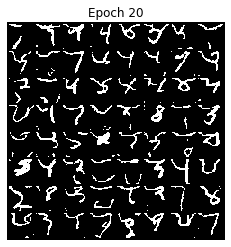

Test Loss 0.20846164226531982


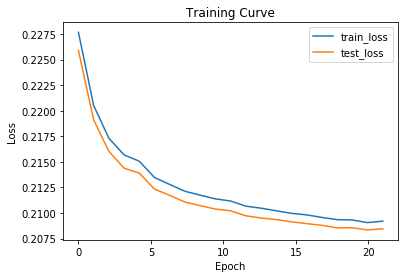

In [82]:
train_epochs(model, train_loader, test_loader, train_args)

## PixelCNN++

PixelCNN typically consists of a stack of masked convolutional layers that takes an $N \times N \times 3$ image as input and produces $N \times N \times 3 \times 256$ (probability of pixel intensity) predictions as output. The softmax layer in PixelCNN to compute the conditional distribution of a sub-pixel is a full of 256-softmax. There are 2 issues with this approache: First, it is very costly in terms of memory. Second, it is missing the continuity property data. It means that the model does not know that a value of 128 is close to a value of 127 or 129 but no different than 255 for instance. 

To address this issue, the paper authors came up with the new model including following modifications compared to PixelCNN:

**Discretized logistic mixture likelihood**

- For each sub-pixel, generate a continuous distribution $ν$ representing the colour intensity instead of discrete distribution. For example, ν could be a mixture of [logistic distribution](https://en.wikipedia.org/wiki/Logistic_distribution) parameterized by $\mu,s$ and the mixture weights $\pi$.
$$
\nu \sim \sum_{i=1}^K \pi_i logistic(\mu_i, s_i) 
$$
- We then convert this intensity to a mass function by assigning regions of it to the 0 to 255 pixels:

$$
\ P(x|\mu,s) =
    \begin{cases}
        \sigma(\frac{x-\mu+0.5}{s}) & \text{for } x = 0 \\
        \sigma(\frac{x-\mu+0.5}{s}) - \sigma(\frac{x-\mu-0.5}{s})
            & \text{for } 0 < x < 255 \\
        1 - \sigma(\frac{x-\mu-0.5}{s}) & \text{for } x = 255
    \end{cases}
\
$$
where $\sigma$ is the sigmoid function.

**Conditioning on whole pixels**  

PixelCNN factorizes the model over the 3 sub pixels according to the color(RGB) which however, complicates the model. The dependency between color channels of a pixel is relatively simple and doesn’t require a deep model to train. Therefore, it is better to condition on whole pixels instead of separate colors and then output joint distributions over all 3 channels of the predicted pixel. 
- We first predict the red channel using a discretized mixture of logistic 
- Next, we predict the green channel using a predictive distribution of the same form. Here we allow the means of the mixture components to linearly depend on the value of the red sub-pixel.  
- Finally, we model the blue channel in the same way, where we again only allow linear dependency on the red and green channels.

**Downsampling versus dilated convolution**   

The PixelCNN uses convolutions with small receptive field which is good at capturing local dependencies,  but not necessarily at modeling long range structure. To overcome this, we downsample the layers by using convolutions of stride 2. Downsampling reduces input size and thus improves relative size of receptive field which leads to some loss of information but it can be compensated by adding extra short-cut connections.   

**Adding short-cut connections**

The idea is pretty the same as [Unet](https://arxiv.org/abs/1505.04597) model by introducing additional short-cut connections into the model to recover the losed informations from lower layers to higher layers of the model.

**Regularization using dropout** 
The PixelCNN model is powerful enough to overfit on training data, leads to  lower perceptual quality of images while generating data. One effective way of regularizing neural networks is [dropout (Srivas-tava et al., 2014)](http://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf).


## WaveNet

All the examples we've seen so far are images generation which is 2D data. The technique of autoregressive generative model can also be applied to 1D data such as audio or text. We will take a look on similar approaches which are based on PixelCNN idea in generating raw audio waveforms, which are signals with very high temporal resolution, at least 16,000 samples per second. One of the most popular applications of this method is **text-to-speech** where we have to generate a audio from text input.

Similarly to PixelCNNs explained above, the joint probability of a waveform $\bf x=\{x_1,...,x_T\}$ is factorised as a product of conditional probabilities of each audio sample $\bf x_t$ which is conditioned on the samples at all previous timesteps. The conditional probability distribution is also modelled by a stack of convolutional layers.

To take care of autoregressive property, the wavenet model is using **casual convolution**. At training time, the conditional predictions for all timesteps can be made in parallel because all timesteps of ground truth $\bf x$ are known.  When generating with the model, the predictions are sequential: after each sample is predicted, it is fed back into the network to predict the next sample. However, one of the problems of causal convolutions is that they require many layers,  or large filters to increase the receptive field. To mitigate this problem, Wavenet used **dilated convolution**

![](my_icons/casual_conv.png "Figure 7: Casual convolution")

### Dilated convolution

A dilated convolution (also called *à trous*, or convolution with holes) is a convolution where the filter is applied over an area larger than its length by skipping input values with a certain step. This technique is broadly used to increase the receptive field by orders of magnitude, without greatly increasing computational cost. In computer vision, we've seen it in semantic segmentation model.

A dilated convolution effectively allows the network to operate ona coarser scale than with a normal convolution. This is similar to pooling or strided convolutions, but here the output has the same size as the input.

![](my_icons/dilated_conv.png "Figure 8: Dilated 2D Convolution")

The intuition is that exponentially increasing the dilation factor results in exponential receptive field growth with depth. So stack these dilated convolutions blocks further increases the model capacity and the receptive field size of the model.

![](my_icons/dilated_conv_1d.png "Figure 9: Dilated convolution in Wavenet")

Except for the dilated convolution, the Wavenet model is very similar to PixelCNN such as gated activation units technique or softmax distribution.

### Fast WaveNet Generation

With the implemenentation of Wavenet in Figure 9, since the computation forms a binary tree, the overall computation time for a single output is $O(2^L)$, where $L$ is the number of layers in the network. When $L$ is large, this is extremely undesirable. This [paper](https://arxiv.org/pdf/1611.09482.pdf) proposed approach removes redundant convolution operations by caching previous calculations instead of recomputing many variables that have already been computed for previous samples, thereby reducing the complexity to $O(L)$ time. 

### Implementation

>The Pytorch code implementation of WaveNet is borrowed from this [repo](https://github.com/ryujaehun/wavenet).   

In [12]:
def append_location(x, device):
    """
        Pixel Location Appended as Features
    """
    idxs = torch.arange(28).float() / 27  # Scale to [0, 1]
    locs = torch.stack(torch.meshgrid(idxs, idxs), dim=-1)
    locs = locs.permute(2, 0, 1).contiguous().unsqueeze(0).repeat(x.shape[0], 1, 1, 1)
    locs = locs.to(device)

    x = torch.cat((x, locs), dim=1)
    return x

class DilatedCausalConv1d(nn.Module):
    """Dilated Causal Convolution for WaveNet"""
    def __init__(self, mask_type, in_channels, out_channels, dilation=1):
        super(DilatedCausalConv1d, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels,
                              kernel_size=2, dilation=dilation, padding=0)
        self.dilation = dilation
        self.mask_type = mask_type
        assert mask_type in ['A', 'B']

    def forward(self, x):
        if self.mask_type == 'A':
            return self.conv(F.pad(x, [2, 0]))[:, :, :-1]
        else:
            return self.conv(F.pad(x, [self.dilation, 0]))


class ResidualBlock(nn.Module):
    """ Gated Unit Activation"""
    def __init__(self, res_channels, dilation):
        super(ResidualBlock, self).__init__()

        self.dilated = DilatedCausalConv1d('B', res_channels, 2 * res_channels, dilation=dilation)
        self.conv_res = nn.Conv1d(res_channels, res_channels, 1)

    def forward(self, x):
        output = self.dilated(x)

        # PixelCNN gate
        o1, o2 = output.chunk(2, dim=1)
        output = torch.tanh(o1) * torch.sigmoid(o2)
        output = x + self.conv_res(output) # Residual network

        return output


class WaveNet(nn.Module):
    def __init__(self, device, append_loc=True):
        super(WaveNet, self).__init__()

        in_channels = 3 if append_loc else 1
        out_channels = 1
        res_channels = 32
        layer_size = 5 # Largest dilation is 16
        stack_size = 2

        self.causal = DilatedCausalConv1d('A', in_channels, res_channels, dilation=1)
        self.res_stack = nn.Sequential(*sum([[ResidualBlock(res_channels, 2 ** i)
                                         for i in range(layer_size)] for _ in range(stack_size)], []))
        self.out_conv = nn.Conv1d(res_channels, out_channels, 1)
        self.append_loc = append_loc
        self.device = device

    def forward(self, x):
        batch_size = x.shape[0]
        if self.append_loc:
            x = append_location(x, self.device)
        output = x.view(batch_size, -1, 784)
        output = self.causal(output)
        output = self.res_stack(output)
        output = self.out_conv(output)
        return output.view(batch_size, 1, 28, 28)

    def nll(self, x):
        x = x.to(self.device)
        logits = self(x)
        return F.binary_cross_entropy_with_logits(logits, x)

    def sample(self, n):
        with torch.no_grad():
            samples = torch.zeros(n, 1, 28, 28).to(self.device)
            for r in range(28):
                for c in range(28):
                    logits = self(samples)[:, :, r, c]
                    probs = torch.sigmoid(logits)
                    samples[:, :, r, c] = torch.bernoulli(probs)
        return samples.cpu()

In [10]:
train_args = {'epochs': 21, 'lr': 0.0002}
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = WaveNet(device).to(device)

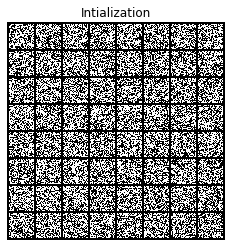

Epoch 0 Test Loss: 0.1659 bits/dim


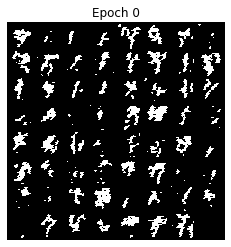

Epoch 10 Test Loss: 0.1265 bits/dim


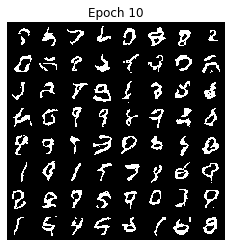

Epoch 20 Test Loss: 0.1240 bits/dim


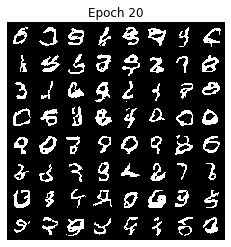

Test Loss 0.08596379309892654


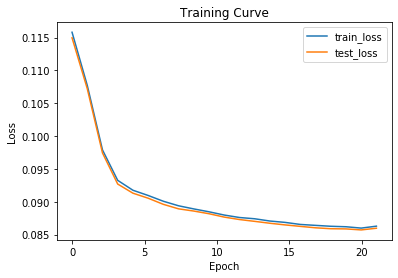

In [11]:
train_epochs(model, train_loader, test_loader, train_args)

## Self-Attention Autoregressive Model

Recently, we've witnessed a tremendous application of Transformer models in NLP. The multi-head self-attention idea behind all these models is approaching many other fields. Explaining in details how it works is out of scope of this post. If you are curious about it, I recommend to take a look on this wonderful [blog](https://jalammar.github.io/illustrated-transformer/). 

The idea of using Transformer on autoregressive generative model is similar with RNN generative model. However, the Transformer is the transduction model relying entirely on self-attention to compute representations of its input and output without using sequence aligned RNNs or convolution.

### Implementation

In [19]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_hid, n_position=784):
        super(PositionalEncoding, self).__init__()

        # Not a parameter
        self.register_buffer('pos_table', self._get_sinusoid_encoding_table(n_position, d_hid))

    def _get_sinusoid_encoding_table(self, n_position, d_hid):
        ''' Sinusoid position encoding table '''

        def get_position_angle_vec(position):
            return [position / np.power(10000, 2 * (hid_j // 2) / d_hid) for hid_j in range(d_hid)]

        sinusoid_table = np.array([get_position_angle_vec(pos_i) for pos_i in range(n_position)])
        sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
        sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1

        return torch.FloatTensor(sinusoid_table).unsqueeze(0) * 0.1

    def forward(self, x):
        return x + self.pos_table[:, :x.size(1)].clone().detach()

class ScaledDotProductAttention(nn.Module):
    ''' Scaled Dot-Product Attention '''

    def __init__(self, temperature, attn_dropout=0.1):
        super().__init__()
        self.temperature = temperature
        self.dropout = nn.Dropout(attn_dropout)

    def forward(self, q, k, v, mask=None):

        attn = torch.matmul(q / self.temperature, k.transpose(2, 3))

        if mask is not None:
            attn = attn.masked_fill(mask == 0, -1e9)

        attn = self.dropout(F.softmax(attn, dim=-1))
        output = torch.matmul(attn, v)

        return output, attn

class PositionwiseFeedForward(nn.Module):
    ''' A two-feed-forward-layer module '''

    def __init__(self, d_in, d_hid, dropout=0.1):
        super().__init__()
        self.w_1 = nn.Linear(d_in, d_hid) # position-wise
        self.w_2 = nn.Linear(d_hid, d_in) # position-wise
        self.layer_norm = nn.LayerNorm(d_in, eps=1e-6)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        residual = x
        x = self.layer_norm(x)

        x = self.w_2(F.relu(self.w_1(x)))
        x = self.dropout(x)
        x += residual

        return x


class MultiHeadAttention(nn.Module):
    ''' Multi-Head Attention module '''

    def __init__(self, n_head, d_model, d_k, d_v, dropout=0.1):
        super().__init__()

        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v

        self.w_qs = nn.Linear(d_model, n_head * d_k, bias=False)
        self.w_ks = nn.Linear(d_model, n_head * d_k, bias=False)
        self.w_vs = nn.Linear(d_model, n_head * d_v, bias=False)
        self.fc = nn.Linear(n_head * d_v, d_model, bias=False)

        self.attention = ScaledDotProductAttention(temperature=d_k ** 0.5)

        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)

    def forward(self, q, k, v, mask=None):
        d_k, d_v, n_head = self.d_k, self.d_v, self.n_head
        sz_b, len_q, len_k, len_v = q.size(0), q.size(1), k.size(1), v.size(1)

        residual = q
        q = self.layer_norm(q)

        # Pass through the pre-attention projection: b x lq x (n*dv)
        # Separate different heads: b x lq x n x dv
        q = self.w_qs(q).view(sz_b, len_q, n_head, d_k)
        k = self.w_ks(k).view(sz_b, len_k, n_head, d_k)
        v = self.w_vs(v).view(sz_b, len_v, n_head, d_v)

        # Transpose for attention dot product: b x n x lq x dv
        q, k, v = q.transpose(1, 2), k.transpose(1, 2), v.transpose(1, 2)

        if mask is not None:
            mask = mask.unsqueeze(0).unsqueeze(0)  # For head axis broadcasting.

        q, attn = self.attention(q, k, v, mask=mask)

        # Transpose to move the head dimension back: b x lq x n x dv
        # Combine the last two dimensions to concatenate all the heads together: b x lq x (n*dv)
        q = q.transpose(1, 2).contiguous().view(sz_b, len_q, -1)
        q = self.dropout(self.fc(q))
        q += residual

        return q

class DecoderLayer(nn.Module):
    ''' Compose with three layers '''

    def __init__(self, d_model, d_inner, n_head, d_k, d_v, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.slf_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn = PositionwiseFeedForward(d_model, d_inner, dropout=dropout)

    def forward(self, dec_input, mask=None):
        dec_output = self.slf_attn(dec_input, dec_input, dec_input, mask=mask)
        dec_output = self.pos_ffn(dec_output)
        return dec_output

class Transformer(nn.Module):
    ''' A decoder model with self attention mechanism. '''

    def __init__(self, device, mode='none'):

        super().__init__()
        n_layers = 2
        self.input_size = 3 if mode == 'pixel_location' else 1

        if mode == 'pos_encoding':
            self.pos_enc = PositionalEncoding(1, n_position=784)
        self.fc_in = nn.Linear(self.input_size, 64)
        self.layer_stack = nn.ModuleList([
            DecoderLayer(64, 64, 1, 16, 64, dropout=0.1)
            for _ in range(n_layers)])
        self.fc_out = nn.Linear(64, 1)

        self.register_buffer('mask', torch.zeros(784, 784))
        for i in range(784):
            self.mask[i, :i] = 1

        self.mode = mode
        self.device = device

    def forward(self, x):
        batch_size = x.shape[0]
        if self.mode == 'pixel_location':
            x = append_location(x, self.device)
            x = x.permute(0, 2, 3, 1).view(batch_size, 784, self.input_size)
        elif self.mode == 'pos_encoding':
            x = x.view(batch_size, 784, self.input_size)
            x = self.pos_enc(x)
        else:
            x = x.view(batch_size, 784, self.input_size)
        x = torch.cat((torch.zeros(batch_size, 1, self.input_size).to(self.device), x[:, :-1]), dim=1)
        # -- Forward
        x = F.relu(self.fc_in(x))
        for i, dec_layer in enumerate(self.layer_stack):
            x = dec_layer(x, mask=self.mask)
        x = self.fc_out(x)
        x = x.view(batch_size, 1, 28, 28)
        return x

    def nll(self, x):
        x = x.to(self.device)
        logits = self(x)
        return F.binary_cross_entropy_with_logits(logits, x)

    def sample(self, n):
        samples = torch.zeros(n, 1, 28, 28).to(self.device)
        with torch.no_grad():
            for r in range(28):
                for c in range(28):
                    logits = self(samples)[:, :, r, c]
                    probs = torch.sigmoid(logits)
                    samples[:, :, r, c] = torch.bernoulli(probs)
        return samples.cpu()

In [20]:
train_args = {'epochs': 21, 'lr': 0.0002}
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Transformer(device, mode='pixel_location').to(device)

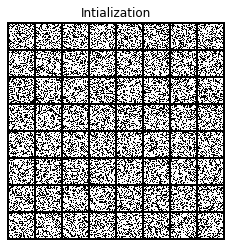

Epoch 0 Test Loss: 0.2513 bits/dim


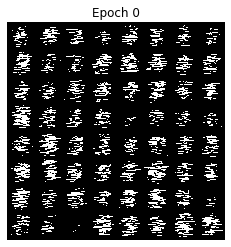

Epoch 10 Test Loss: 0.1693 bits/dim


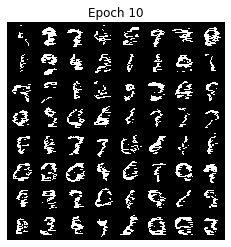

Epoch 20 Test Loss: 0.1486 bits/dim


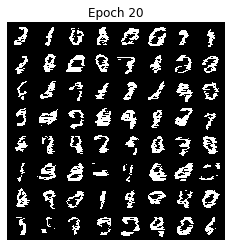

Test Loss 0.10297279804944992


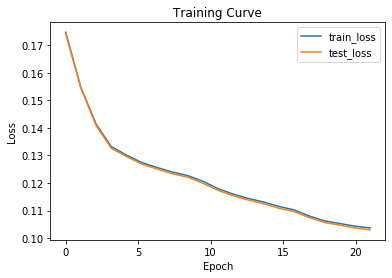

In [21]:
train_epochs(model, train_loader, test_loader, train_args)

## PixelSNAIL

We've already covered a lot til now (Yeah! I know...). The last model we will review is PixelSNAIL which adopt masked self-attention approaches inspired by [SNAIL](https://arxiv.org/pdf/1707.03141.pdf).    
The key idea behind PixelSNAIL is to introduce attention blocks, in a style similar to Self Attention, into neural autoregressive modelling.   
The PixelSNAIL model is composed of two blocks: 

- Residual block: This block is as same as gated unit block in PixelCNN that we've seen so far. 

- Attention block: This block performs a single key-value lookup.  It projects the input to a lower dimensionality to produce the keys and values and then uses softmax-attention like in Transformer model.

![](my_icons/pixelSNAIL.png "Figure 10: PixelSNAIL block")

The way how PixelSNAIL integrated self-attention blocks is quite interesting because it allows to model long-range depenencies between pixels in image, equip all conditionals with the ability to refer to all of their available context. Moreover, each conditional can access any pixels in its context through the attention operator, easy information access of remote pixels improves modeling of long-range statistics. 

![](my_icons/pixelSNAIL_arch.png "Figure 11: PixelSNAIL architecture")

### Flexible ordering 

We've seen in PixelCNN or other architectures, the pixel ordering is raster scanning where along each row left  pixels  come  before  right  pixels  and  top  rows  come before bottom rows. The raster scan order-ing only has a small number neighboring pixels available in the conditioning context $\bf x_1, . . . , x_{i−1}$:  only to the left and above and most of the context is wasted on regions that might have little correlation with the current pixel like the far top-right corner. Since we can access any pixels in its context through attention operator, PixelSNAIL allows zigzag ordering.

![](my_icons/pixels-ordering.png "Figure 12: Pixels ordering")

# Reference

[1]. [Deep Unsupervised Learning course -- UC Berkeley](https://sites.google.com/view/berkeley-cs294-158-sp20/home)    
[2]. Brian Keng [Autoregressive autoencoder](http://bjlkeng.github.io/posts/autoregressive-autoencoders/)     
[3]. Bengio et al. 2014 [Representation Learning: A Review and NewPerspectives](https://arxiv.org/pdf/1206.5538.pdf)    
[4] [wiki notes- Conditional Image Generation with PixelCNN Decoders](https://wiki.math.uwaterloo.ca/statwiki/index.php?title=STAT946F17/Conditional_Image_Generation_with_PixelCNN_Decoders)   
[5]. Van den Oord et al. 2016 [Pixel Recurrent Neural Networks](https://arxiv.org/pdf/1601.06759.pdf). ICML 2016.    
[6]. Van den Oord et al. 2016 [Conditional Image Generation with PixelCNN Decoders](https://arxiv.org/pdf/1606.05328.pdf)    
[7] Tim Salimans, Andrej Karpathy, Xi Chen, Diederik P. Kingma [PixelCNN++ A PixelCNN Implementation with Discretized Logistic Mixture Likelihood and Other Modifications](https://arxiv.org/pdf/1701.05517.pdf)   
[8] Germain, Mathieu, Karol Gregor, Iain Murray, and Hugo Larochelle. [Made: Masked autoencoder for distribution estimation](https://arxiv.org/pdf/1502.03509.pdf) ICML 2015.     
[9] https://towardsdatascience.com/auto-regressive-generative-models-pixelrnn-pixelcnn-32d192911173    
[10] Fisher Yu, Vladlen Koltun [Multi-scale context aggregation by dilated convolution](https://arxiv.org/pdf/1511.07122.pdf).  ICLR 2016     
[11] Van den Oord et al. 2016 [WaveNet - A generative model for raw audio](https://arxiv.org/pdf/1609.03499.pdf)   
[12] Tom Le Paine1, Pooya Khorram, Shiyu Chang, Yang Zhang ,Prajit Ramachandran, Mark A. Hasegawa-Johnson & Thomas S. Huang. 2016 [Fast Wavenet generation model](https://arxiv.org/pdf/1611.09482.pdf)   
[13] Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Łukasz Kaiser [Attention is All You Need](https://arxiv.org/pdf/1706.03762.pdf)     
[14] Jay Alammar [Illustrated transformer](https://jalammar.github.io/illustrated-transformer/)     
[15] Xi Chen, Nikhil Mishra, Mostafa Rohaninejad, Pieter Abbee [PixelSNAIL: An Improved Autoregressive Generative Model](https://arxiv.org/pdf/1712.09763.pdf)